In [4]:
import evolving_SBM_generate
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from math import sqrt, pi, exp

In [26]:
activ_tau=1/20
inter_tau=2
m = lambda t: inter_tau/activ_tau * (1- np.exp(-t / inter_tau))

In [27]:
n_events, start_times, end_times = evolving_SBM_generate.EDEDE(activ_tau= activ_tau, inter_tau= inter_tau, t_start=0, t_end=100)
time_grid, activity = evolving_SBM_generate.activity_EDEDE(start_times, end_times)

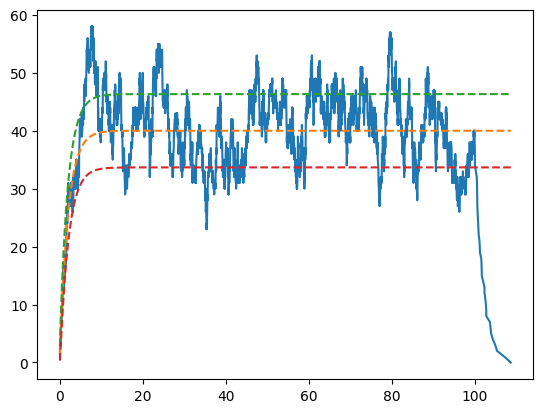

In [34]:
average_edede = [m(t) for t in time_grid]
plt.plot(time_grid, activity)
plt.plot(time_grid, average_edede, '--')
plt.plot(time_grid, average_edede + np.sqrt(average_edede), '--')
plt.plot(time_grid, average_edede - np.sqrt(average_edede), '--')

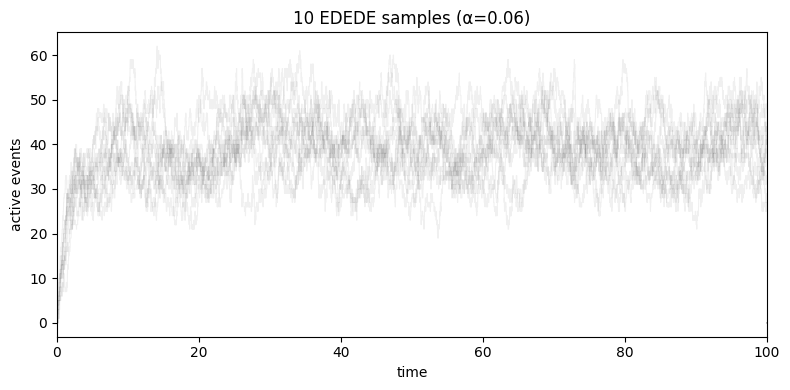

In [ ]:
# Params (adjust as needed)
n_samples = 10
t_start, t_end = 0, 100
alpha_each = 0.06  # transparency per path
lw_each = 0.8

activ_tau=1/20
inter_tau=2

fig, ax = plt.subplots(figsize=(8, 4))

def plot_activity_realization(ax, start_times, end_times, t_start, t_end, **step_kwargs):
    # Get change times and right-continuous counts
    change_times, counts_after = evolving_SBM_generate.activity_EDEDE(start_times, end_times)

    if len(change_times) == 0:
        # No events: flat zero
        ax.hlines(0, t_start, t_end, **{k: v for k, v in step_kwargs.items() if k not in ("where",)})
        return

    # Build a full right-continuous step from t_start to t_end
    xs = [t_start] + list(change_times) + [t_end]
    ys = [0] + list(counts_after) + [counts_after[-1]]

    ax.step(xs, ys, where="post", **step_kwargs)

for _ in range(n_samples):
    n_events, start_times, end_times = evolving_SBM_generate.EDEDE(
        activ_tau=activ_tau, inter_tau=inter_tau, t_start=t_start, t_end=t_end
    )
    plot_activity_realization(
        ax, start_times, end_times, t_start, t_end,
        color="k", alpha=alpha_each, linewidth=lw_each
    )

ax.set_xlim(t_start, t_end)
ax.set_xlabel("time")
ax.set_ylabel("active events")
ax.set_title(f"{n_samples} EDEDE samples (α={alpha_each})")

plt.tight_layout()
plt.show()

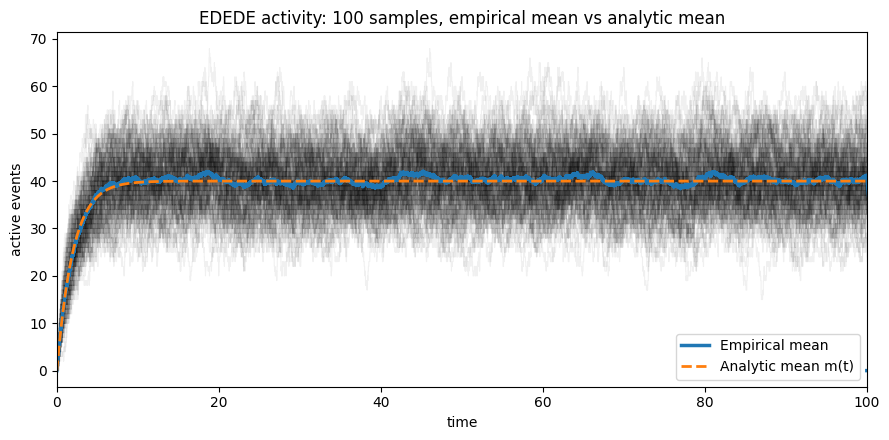

In [5]:
# --- Params (adjust as needed) ---
n_samples = 100
t_start, t_end = 0.0, 100.0
alpha_each = 0.06
lw_each = 0.8

activ_tau=1/20
inter_tau=2

# --- Analytic mean m(t) ---
def m_of_t(t, activ_tau, inter_tau, t_start, t_end):
    lam = 1.0 / activ_tau     # arrival rate
    mu  = inter_tau           # mean lifetime
    if t < t_start:
        return 0.0
    elif t <= t_end:
        return lam * mu * (1.0 - np.exp(-(t - t_start)/mu))
    else:
        return lam * mu * (np.exp(-(t - t_end)/mu) - np.exp(-(t - t_start)/mu))

# Helper: build a right-continuous step from change_times/counts
def step_full_span(change_times, counts_after, t_start, t_end):
    if len(change_times) == 0:
        return [t_start, t_end], [0, 0]
    xs = [t_start] + list(change_times) + [t_end]
    ys = [0] + list(counts_after) + [counts_after[-1]]
    return xs, ys

# --- Draw samples and collect for averaging ---
fig, ax = plt.subplots(figsize=(9, 4.5))

starts_list = []
ends_list   = []

for _ in range(n_samples):
    n_events, start_times, end_times = evolving_SBM_generate.EDEDE(
        activ_tau=activ_tau, inter_tau=inter_tau, t_start=t_start, t_end=t_end
    )
    starts_list.append(start_times)
    ends_list.append(end_times)

    # plot this realization faintly
    ct, ca = evolving_SBM_generate.activity_EDEDE(start_times, end_times)
    xs, ys = step_full_span(ct, ca, t_start, t_end)
    ax.step(xs, ys, where="post", color="k", alpha=alpha_each, linewidth=lw_each)

# --- Empirical average as a step over the union of change times ---
sum_delta = defaultdict(float)  # time -> sum of (+1/-1) deltas across all samples
for starts, ends in zip(starts_list, ends_list):
    for s in starts: sum_delta[s] += 1.0
    for e in ends:   sum_delta[e] -= 1.0

# Build averaged step (right-continuous, [start,end))
times_all = sorted(sum_delta.keys())
avg_times = []
avg_counts = []
cur = 0.0
for t in times_all:
    delta = sum_delta[t] / n_samples
    if delta != 0.0:
        cur += delta
        avg_times.append(t)
        avg_counts.append(cur)

# Full-span step for plotting
if len(avg_times) == 0:
    xs_avg, ys_avg = [t_start, t_end], [0.0, 0.0]
else:
    xs_avg = [t_start] + avg_times + [t_end]
    ys_avg = [0.0] + avg_counts + [avg_counts[-1]]

ax.step(xs_avg, ys_avg, where="post", linewidth=2.5, label="Empirical mean")

# --- Analytic mean curve on a dense grid ---
t_eval = np.linspace(t_start, t_end, 800)
m_eval = [m_of_t(t, activ_tau, inter_tau, t_start, t_end) for t in t_eval]
ax.plot(t_eval, m_eval, linestyle="--", linewidth=2, label="Analytic mean m(t)")

# --- Decorate ---
ax.set_xlim(t_start, t_end)
ax.set_xlabel("time")
ax.set_ylabel("active events")
ax.set_title(f"EDEDE activity: {n_samples} samples, empirical mean vs analytic mean")
ax.legend()
plt.tight_layout()
plt.show()

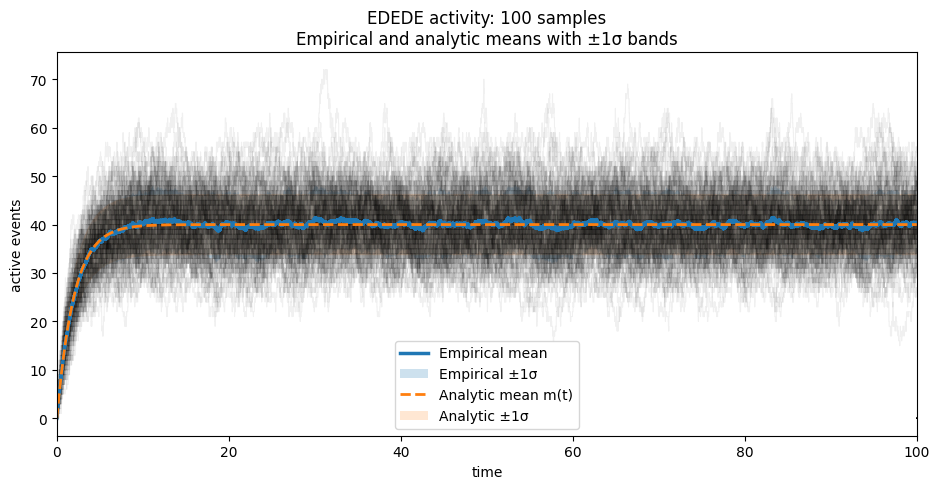

In [6]:
# --- Params (adjust as needed) ---
n_samples = 100
t_start, t_end = 0.0, 100.0
alpha_each = 0.06   # transparency for individual paths
lw_each = 0.8

activ_tau=1/20
inter_tau=2

# --- Analytic mean m(t) ---
def m_of_t(t, activ_tau, inter_tau, t_start, t_end):
    lam = 1.0 / activ_tau     # arrival rate
    mu  = inter_tau           # mean lifetime
    if t < t_start:
        return 0.0
    elif t <= t_end:
        return lam * mu * (1.0 - np.exp(-(t - t_start)/mu))
    else:
        return lam * mu * (np.exp(-(t - t_end)/mu) - np.exp(-(t - t_start)/mu))

# Helper: full-span right-continuous step for one realization
def step_full_span(change_times, counts_after, t_start, t_end):
    if len(change_times) == 0:
        return [t_start, t_end], [0, 0]
    xs = [t_start] + list(change_times) + [t_end]
    ys = [0] + list(counts_after) + [counts_after[-1]]
    return xs, ys

fig, ax = plt.subplots(figsize=(9.5, 5))

# --- Draw samples, store starts/ends for averaging ---
starts_list = []
ends_list   = []

for _ in range(n_samples):
    n_events, start_times, end_times = evolving_SBM_generate.EDEDE(
        activ_tau=activ_tau, inter_tau=inter_tau, t_start=t_start, t_end=t_end
    )
    starts_list.append(start_times)
    ends_list.append(end_times)

    # plot this realization faintly
    ct, ca = evolving_SBM_generate.activity_EDEDE(start_times, end_times)
    xs, ys = step_full_span(ct, ca, t_start, t_end)
    ax.step(xs, ys, where="post", color="k", alpha=alpha_each, linewidth=lw_each)

# --- Build union of change times across all samples (include endpoints) ---
times_all = set([t_start, t_end])
for starts, ends in zip(starts_list, ends_list):
    times_all.update(starts)
    times_all.update(ends)
times_all = sorted(times_all)

# --- Compute empirical counts at each time for each sample (right-continuous) ---
counts_mat = np.zeros((n_samples, len(times_all)), dtype=float)

for i, (starts, ends) in enumerate(zip(starts_list, ends_list)):
    delta = defaultdict(int)
    for s in starts: delta[s] += 1
    for e in ends:   delta[e] -= 1
    cur = 0
    row = counts_mat[i]
    for j, t in enumerate(times_all):
        cur += delta.get(t, 0)  # count AFTER time t (right-continuous)
        row[j] = cur

# --- Empirical mean and std over samples ---
if n_samples > 1:
    emp_mean = counts_mat.mean(axis=0)
    emp_std  = counts_mat.std(axis=0, ddof=1)  # sample std
else:
    emp_mean = counts_mat[0]
    emp_std  = np.zeros_like(emp_mean)

# --- Plot empirical mean + shaded ±1σ (step style) ---
ax.step(times_all, emp_mean, where="post", linewidth=2.5, label="Empirical mean")
lower_emp = np.clip(emp_mean - emp_std, 0, None)
upper_emp = emp_mean + emp_std
ax.fill_between(times_all, lower_emp, upper_emp, step="post", alpha=0.22, label="Empirical ±1σ")

# --- Analytic mean and ±√m(t) band on a dense grid ---
t_dense = np.linspace(t_start, t_end, 1200)
m_dense = np.array([m_of_t(t, activ_tau, inter_tau, t_start, t_end) for t in t_dense])
sd_dense = np.sqrt(np.clip(m_dense, 0, None))
ax.plot(t_dense, m_dense, linestyle="--", linewidth=2, label="Analytic mean m(t)")
ax.fill_between(t_dense, np.clip(m_dense - sd_dense, 0, None), m_dense + sd_dense, alpha=0.18, label="Analytic ±1σ")

# --- Decorate ---
ax.set_xlim(t_start, t_end)
ax.set_xlabel("time")
ax.set_ylabel("active events")
ax.set_title(f"EDEDE activity: {n_samples} samples\nEmpirical and analytic means with ±1σ bands")
ax.legend()
plt.tight_layout()
plt.show()

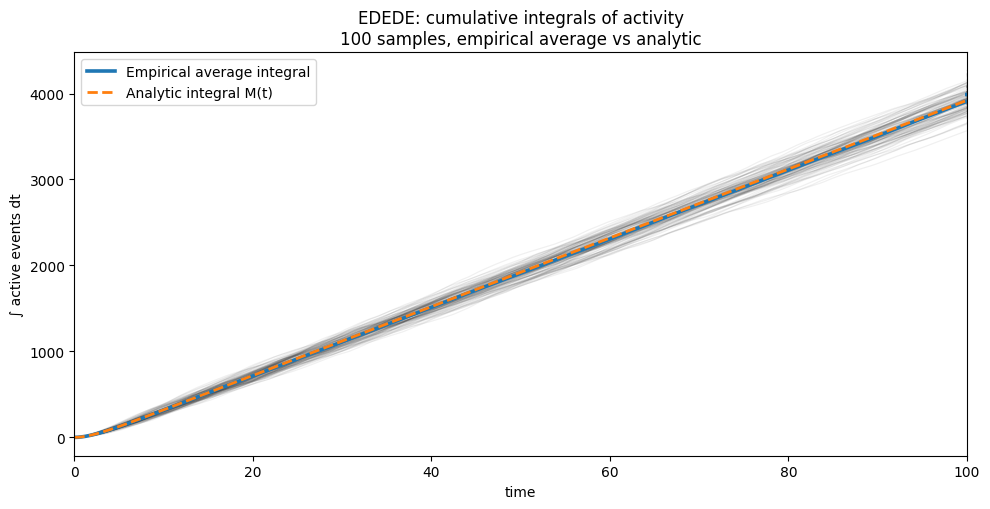

In [3]:
# --- Params (adjust as needed) ---
n_samples = 100
t_start, t_end = 0.0, 100.0
alpha_each = 0.06   # transparency for individual integral curves
lw_each = 0.9

activ_tau=1/20
inter_tau=2

# --- Analytic mean m(t) and its integral M(t) ---
def m_of_t(t, activ_tau, inter_tau, t_start, t_end):
    lam = 1.0 / activ_tau     # arrival rate
    mu  = inter_tau           # mean lifetime
    if t < t_start:
        return 0.0
    elif t <= t_end:
        return lam * mu * (1.0 - np.exp(-(t - t_start)/mu))
    else:
        return lam * mu * (np.exp(-(t - t_end)/mu) - np.exp(-(t - t_start)/mu))

def M_of_t_vec(t_vec, activ_tau, inter_tau, t_start, t_end):
    """Vectorized analytic integral M(t) = ∫ m(s) ds."""
    lam = 1.0 / activ_tau
    mu  = inter_tau
    W   = t_end - t_start
    t   = np.asarray(t_vec)

    M = np.zeros_like(t, dtype=float)

    # Region 1: t in [t_start, t_end]
    mask1 = (t >= t_start) & (t <= t_end)
    u = t[mask1] - t_start
    M[mask1] = lam*mu*( u - mu*(1.0 - np.exp(-u/mu)) )

    # Region 2: t > t_end
    mask2 = t > t_end
    u2 = t[mask2] - t_end
    M_end = lam*mu*( W - mu*(1.0 - np.exp(-W/mu)) )
    part = lam*(mu**2) * ( 1.0 - np.exp(-u2/mu) - np.exp(-W/mu) + np.exp(-(u2+W)/mu) )
    M[mask2] = M_end + part

    return M

# --- Helpers for steps and integrals ---
def step_full_span(change_times, counts_after, t_start, t_end):
    """Build right-continuous step arrays xs, ys with where='post' semantics."""
    if len(change_times) == 0:
        return [t_start, t_end], [0.0, 0.0]
    xs = [t_start] + list(change_times) + [t_end]
    ys = [0.0]     + list(counts_after) + [counts_after[-1]]
    return xs, ys

def integral_curve_from_step(xs, ys):
    """
    Given a right-continuous step (ys[i] on [xs[i], xs[i+1])),
    return cumulative integral F with F[0]=0 at xs[0].
    """
    F = [0.0]
    for i in range(len(xs)-1):
        dt = xs[i+1] - xs[i]
        F.append(F[-1] + ys[i] * dt)
    return np.asarray(xs), np.asarray(F)

fig, ax = plt.subplots(figsize=(10, 5.2))

# --- Draw samples, store starts/ends for empirical mean ---
starts_list = []
ends_list   = []

for _ in range(n_samples):
    n_events, start_times, end_times = evolving_SBM_generate.EDEDE(
        activ_tau=activ_tau, inter_tau=inter_tau, t_start=t_start, t_end=t_end
    )
    starts_list.append(start_times)
    ends_list.append(end_times)

    # activity as a step, then cumulative integral curve (piecewise linear)
    ct, ca = evolving_SBM_generate.activity_EDEDE(start_times, end_times)
    xs, ys = step_full_span(ct, ca, t_start, t_end)
    xs_int, F = integral_curve_from_step(xs, ys)

    # plot this realization's integral curve faintly
    ax.plot(xs_int, F, color="k", alpha=alpha_each, linewidth=lw_each)

# --- Empirical mean activity step via union-of-deltas (no resampling of curves needed) ---
sum_delta = defaultdict(float)  # time -> sum of (+1/-1) deltas across all samples
for starts, ends in zip(starts_list, ends_list):
    for s in starts: sum_delta[s] += 1.0
    for e in ends:   sum_delta[e] -= 1.0

avg_times = []
avg_counts = []
cur = 0.0
for t in sorted(sum_delta.keys()):
    delta = sum_delta[t] / n_samples
    if delta != 0.0:
        cur += delta
        avg_times.append(t)
        avg_counts.append(cur)

# Build full-span mean step and integrate it to get the **average integral curve**
if len(avg_times) == 0:
    xs_mean, ys_mean = [t_start, t_end], [0.0, 0.0]
else:
    xs_mean = [t_start] + avg_times + [t_end]
    ys_mean = [0.0] + avg_counts + [avg_counts[-1]]

xs_mean_int, F_mean = integral_curve_from_step(xs_mean, ys_mean)
ax.plot(xs_mean_int, F_mean, linewidth=2.6, label="Empirical average integral")

# --- Analytic integral curve M(t) (optional overlay) ---
t_dense = np.linspace(t_start, t_end, 1200)
M_dense = M_of_t_vec(t_dense, activ_tau, inter_tau, t_start, t_end)
ax.plot(t_dense, M_dense, linestyle="--", linewidth=2, label="Analytic integral M(t)")

# --- Decorate ---
ax.set_xlim(t_start, t_end)
ax.set_xlabel("time")
ax.set_ylabel("∫ active events dt")
ax.set_title(f"EDEDE: cumulative integrals of activity\n{n_samples} samples, empirical average vs analytic")
ax.legend()
plt.tight_layout()
plt.show()

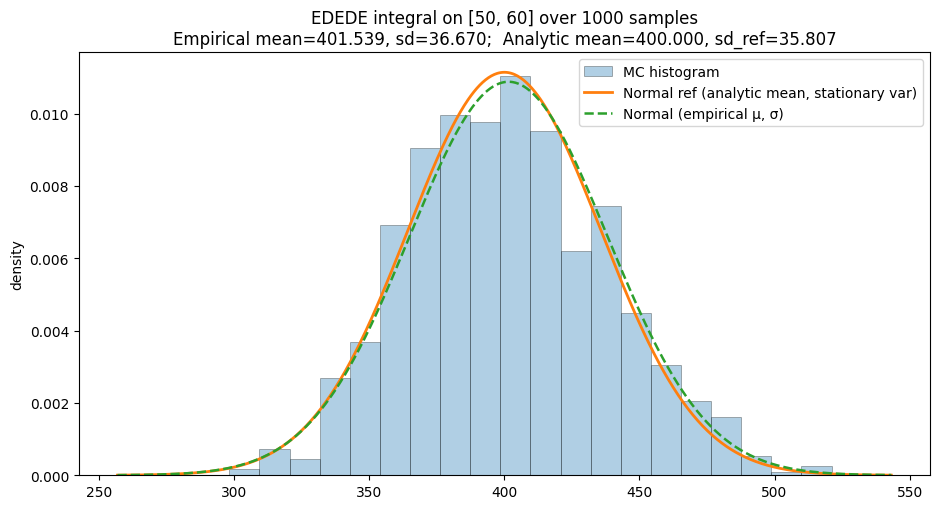

In [10]:
# --- Parameters (tweak as needed) ---
n_samples = 1000
t_start, t_end = 0.0, 100.0
t1, t2 = 50.0, 60.0   # sub-interval where we're (essentially) at steady-state
L = t2 - t1

activ_tau=1/20
inter_tau=2

# You already have these in scope in your notebook:
# activ_tau, inter_tau
lam = 1.0 / activ_tau   # arrival rate
mu  = inter_tau         # mean lifetime

# --- Analytic mean m(t) for EDEDE (arrivals only in [t_start,t_end]) ---
def m_of_t(t, activ_tau, inter_tau, t_start, t_end):
    lam = 1.0 / activ_tau
    mu  = inter_tau
    if t < t_start:
        return 0.0
    elif t <= t_end:
        return lam * mu * (1.0 - np.exp(-(t - t_start)/mu))
    else:
        return lam * mu * (np.exp(-(t - t_end)/mu) - np.exp(-(t - t_start)/mu))

# Analytic integral M(t) = ∫_{t_start}^t m(s) ds (closed-form for our finite arrival window)
def M_of_t_vec(t_vec, activ_tau, inter_tau, t_start, t_end):
    lam = 1.0 / activ_tau
    mu  = inter_tau
    W   = t_end - t_start
    t   = np.asarray(t_vec, dtype=float)
    M = np.zeros_like(t)

    # region 1: t in [t_start, t_end]
    mask1 = (t >= t_start) & (t <= t_end)
    u = t[mask1] - t_start
    M[mask1] = lam*mu*( u - mu*(1.0 - np.exp(-u/mu)) )

    # region 2: t > t_end
    mask2 = t > t_end
    u2 = t[mask2] - t_end
    M_end = lam*mu*( W - mu*(1.0 - np.exp(-W/mu)) )
    # tail contribution
    M[mask2] = M_end + lam*(mu**2) * ( 1.0 - np.exp(-u2/mu) - np.exp(-W/mu) + np.exp(-(u2+W)/mu) )
    return M

# Build full-span right-continuous step arrays from activity_EDEDE output
def step_full_span(change_times, counts_after, t_start, t_end):
    if len(change_times) == 0:
        return np.array([t_start, t_end], float), np.array([0.0, 0.0], float)
    xs = np.array([t_start] + list(change_times) + [t_end], float)
    ys = np.array([0.0] + list(counts_after) + [counts_after[-1]], float)
    return xs, ys

# Integral of a right-continuous step over [a,b] as sum(count * overlap_length)
def integral_over_interval_from_step(xs, ys, a, b):
    # segments are [xs[i], xs[i+1]) with value ys[i]
    left  = xs[:-1]
    right = xs[1:]
    vals  = ys[:-1]
    # intersection length with [a,b]
    overlap = np.maximum(0.0, np.minimum(right, b) - np.maximum(left, a))
    return float(np.dot(vals, overlap))

# --- Monte Carlo: sample trajectories, integrate on [t1, t2] ---
areas = np.empty(n_samples, dtype=float)

for i in range(n_samples):
    n_events, start_times, end_times = evolving_SBM_generate.EDEDE(
        activ_tau=activ_tau, inter_tau=inter_tau, t_start=t_start, t_end=t_end
    )
    ct, ca = evolving_SBM_generate.activity_EDEDE(start_times, end_times)
    xs, ys = step_full_span(ct, ca, t_start, t_end)
    areas[i] = integral_over_interval_from_step(xs, ys, t1, t2)

# --- Reference Normal: mean from finite-window analytic M(t), variance from stationary approximation ---
mean_analytic = float(M_of_t_vec([t2], activ_tau, mu, t_start, t_end)[0]
                      - M_of_t_vec([t1], activ_tau, mu, t_start, t_end)[0])
# Stationary M/M/∞ variance for window length L (good when t1 - t_start >> mu and t_end - t2 >> mu)
var_stationary = 2.0 * lam * (mu**2) * (L - mu * (1.0 - np.exp(-L/mu)))
sd_stationary = sqrt(max(var_stationary, 0.0))

# Also compute empirical mean/SD for sanity check
mean_emp = float(np.mean(areas))
sd_emp   = float(np.std(areas, ddof=1))

# --- Plot histogram + reference normal pdf ---
fig, ax = plt.subplots(figsize=(9.5, 5.2))
# histogram as density
ax.hist(areas, bins=20, density=True, alpha=0.35, edgecolor='k', linewidth=0.6, label="MC histogram")

# x-grid for pdf
x_min = min(areas.min(), mean_analytic - 4*sd_stationary)
x_max = max(areas.max(), mean_analytic + 4*sd_stationary)
x = np.linspace(x_min, x_max, 800)

# normal pdf with analytic mean and stationary variance
if sd_stationary > 0:
    pdf_ref = (1.0/(sd_stationary*sqrt(2*pi))) * np.exp(-0.5*((x - mean_analytic)/sd_stationary)**2)
    ax.plot(x, pdf_ref, linewidth=2.0, label="Normal ref (analytic mean, stationary var)")

# (optional) dashed normal with empirical mean/sd to visualize fit quality
pdf_emp = (1.0/(sd_emp*sqrt(2*pi))) * np.exp(-0.5*((x - mean_emp)/sd_emp)**2)
ax.plot(x, pdf_emp, linestyle="--", linewidth=1.8, label="Normal (empirical μ, σ)")

# decorations
#ax.set_xlabel(fr"Integral $\displaystyle \int_{%g}^{%g} N(t)\,dt$" % (t1, t2))
ax.set_ylabel("density")
ax.set_title(f"EDEDE integral on [{t1:g}, {t2:g}] over {n_samples} samples\n"
             f"Empirical mean={mean_emp:.3f}, sd={sd_emp:.3f};  Analytic mean={mean_analytic:.3f}, sd_ref={sd_stationary:.3f}")
             
ax.legend()
plt.tight_layout()
plt.show()